In [1]:
import matplotlib.pyplot as plt
import numpy as np
import neurobiases
import neurobiases.ITSFASolver as isolver

from importlib import reload
from neurobiases import TriangularModel, TCSolver, EMSolver
from neurobiases import utils, plot
from sklearn.linear_model import LinearRegression
%matplotlib inline

# Experiment 1: Examine whether fits change as a function of identifiability transform

In [7]:
# create triangular model kwargs
tuning_kwargs, coupling_kwargs, noise_kwargs, stim_kwargs = \
    TriangularModel.generate_piecewise_kwargs(M=15, N=20, K=1,
                                              corr_cluster=0.2, corr_back=0.0,
                                              tuning_sparsity=0.6, coupling_sparsity=0.5,
                                              tuning_random_state=233332, coupling_random_state=2)

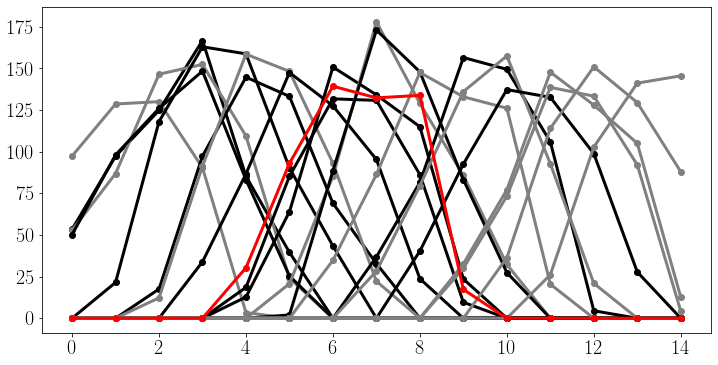

In [8]:
# create triangular model and examine tuning curves
tm = TriangularModel(
    model='linear',
    parameter_design='piecewise',
    tuning_kwargs=tuning_kwargs,
    coupling_kwargs=coupling_kwargs,
    noise_kwargs=noise_kwargs,
    stim_kwargs=stim_kwargs
)
tm.plot_tuning_curves(neuron='all')
plt.show()

In [9]:
n_deltas = 1000
n_reps = 25
deltas = np.linspace(-10, 10, n_deltas)
a_start = np.copy(tm.a.ravel())
b_start = np.copy(tm.b.ravel())
a_hats = np.zeros((n_deltas, n_reps, tm.N))
b_hats = np.zeros((n_deltas, n_reps, tm.M))

In [10]:
# calculate tuning/coupling parameters for each identifiability parameters
for idx, delta in enumerate(deltas):
    tm.identifiability_transform(delta=delta)
    for rep in range(n_reps):
        X, Y, y = tm.generate_samples(n_samples=1000)
        solver = TCSolver(X, Y, y, a_mask=a_start != 0, b_mask=b_start != 0)
        a_hats[idx, rep], b_hats[idx, rep] = solver.fit_ols()
    tm.identifiability_transform(delta=-delta)

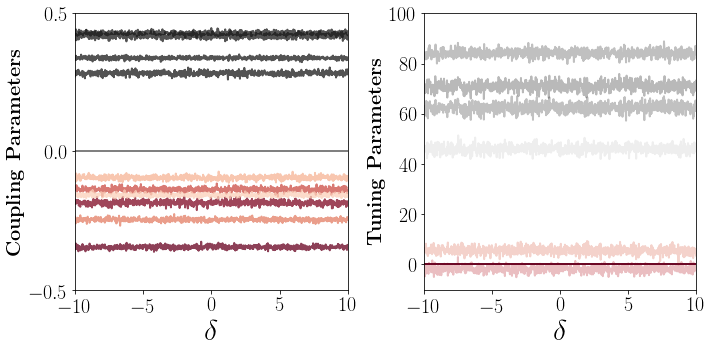

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# iterate over coupling parameters
for idx in range(tm.N):
    # plot trajectory of parameter over delta
    axes[0].plot(deltas, np.mean(a_hats[:, :, idx], axis=1),
                 color=plot.get_cmap_color('RdGy', a_start[idx], a_start.min(), a_start.max()),
                 alpha=0.75,
                 linewidth=2)

# iterate over coupling parameters
for idx in range(tm.M):
    # plot trajectory of parameter over delta
    axes[1].plot(deltas, np.mean(b_hats[:, :, idx], axis=1),
                 color=plot.get_cmap_color('RdGy', b_start[idx], b_start.min(), b_start.max()),
                 alpha=0.30,
                 linewidth=2)
    
axes[0].set_ylim([-0.5, 0.5])
axes[0].set_yticks([-0.5, 0, 0.5])
axes[1].set_ylim([-10, 100])

axes[0].set_ylabel(r'\textbf{Coupling Parameters}', fontsize=20)
axes[1].set_ylabel(r'\textbf{Tuning Parameters}', fontsize=20)

for ax in axes:
    ax.set_xlim([-10, 10])
    ax.set_xlabel(r'$\delta$', fontsize=30)

plt.tight_layout()
plt.savefig('fits_vs_identifiability_same_selection.pdf', bbox_inches='tight')

# Experiment 2: Examine how a different selection profile impacts the fit

In [12]:
# create triangular model kwargs
tuning_kwargs, coupling_kwargs, noise_kwargs, stim_kwargs = \
    TriangularModel.generate_piecewise_kwargs(M=15, N=20, K=1,
                                              corr_cluster=0.2, corr_back=0.0,
                                              tuning_sparsity=0.6, coupling_sparsity=0.5,
                                              tuning_random_state=233332, coupling_random_state=2)

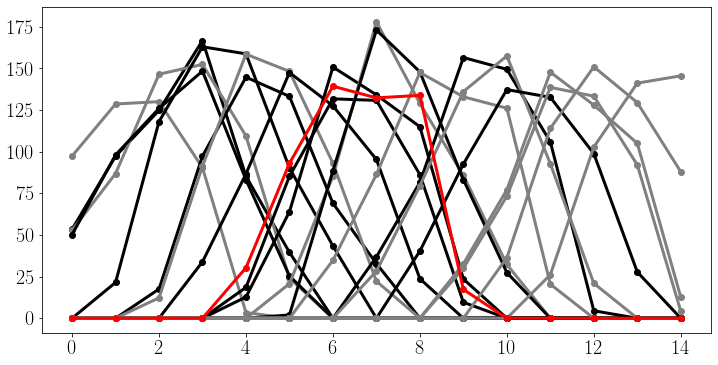

In [13]:
# create triangular model and examine tuning curves
tm = TriangularModel(
    model='linear',
    parameter_design='piecewise',
    tuning_kwargs=tuning_kwargs,
    coupling_kwargs=coupling_kwargs,
    noise_kwargs=noise_kwargs,
    stim_kwargs=stim_kwargs
)
tm.plot_tuning_curves(neuron='all')
plt.show()

In [14]:
n_deltas = 1000
n_reps = 100
deltas = np.linspace(-110, 75, n_deltas)
a_start = np.copy(tm.a.ravel())
b_start = np.copy(tm.b.ravel())
a_hats = np.zeros((n_deltas, n_reps, tm.N))
a_trues = np.zeros((n_deltas, tm.N))
b_hats = np.zeros((n_deltas, n_reps, tm.M))
b_trues = np.zeros((n_deltas, tm.M))

In [15]:
# calculate tuning/coupling parameters for each identifiability parameters
for idx, delta in enumerate(deltas):
    tm.identifiability_transform(delta=delta)
    a_trues[idx] = tm.a.ravel()
    b_trues[idx] = tm.b.ravel()
    
    for rep in range(n_reps):
        X, Y, y = tm.generate_samples(n_samples=1000)
        solver = TCSolver(X, Y, y, a_mask=None, b_mask=None)
        a_hats[idx, rep], b_hats[idx, rep] = solver.fit_ols()
    tm.identifiability_transform(delta=-delta)

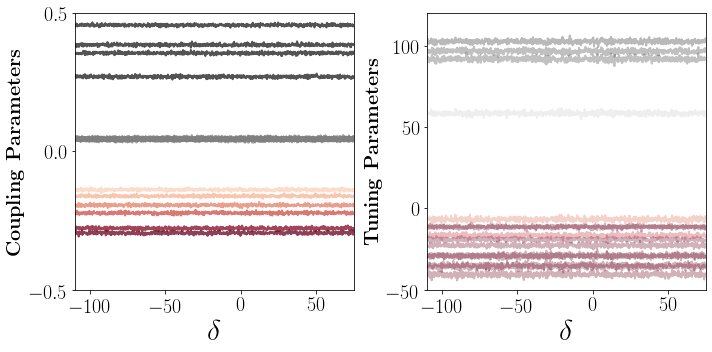

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# iterate over coupling parameters
for idx in range(tm.N):
    # plot trajectory of parameter over delta
    axes[0].plot(deltas, np.mean(a_hats[:, :, idx], axis=1),
                 color=plot.get_cmap_color('RdGy', a_start[idx], a_start.min(), a_start.max()),
                 alpha=0.75,
                 linewidth=2)

# iterate over coupling parameters
for idx in range(tm.M):
    # plot trajectory of parameter over delta
    axes[1].plot(deltas, np.mean(b_hats[:, :, idx], axis=1),
                 color=plot.get_cmap_color('RdGy', b_start[idx], b_start.min(), b_start.max()),
                 alpha=0.30,
                 linewidth=2)
    
axes[0].set_ylim([-0.5, 0.5])
axes[0].set_yticks([-0.5, 0, 0.5])
axes[1].set_ylim([-50, 120])

axes[0].set_ylabel(r'\textbf{Coupling Parameters}', fontsize=20)
axes[1].set_ylabel(r'\textbf{Tuning Parameters}', fontsize=20)

for ax in axes:
    ax.set_xlim([-110, 75])
    ax.set_xlabel(r'$\delta$', fontsize=30)

plt.tight_layout()
plt.savefig('fits_vs_identifiability_no_selection.pdf', bbox_inches='tight')

In [17]:
a_hat = np.mean(a_hats, axis=(0, 1))
b_hat = np.mean(b_hats, axis=(0, 1))

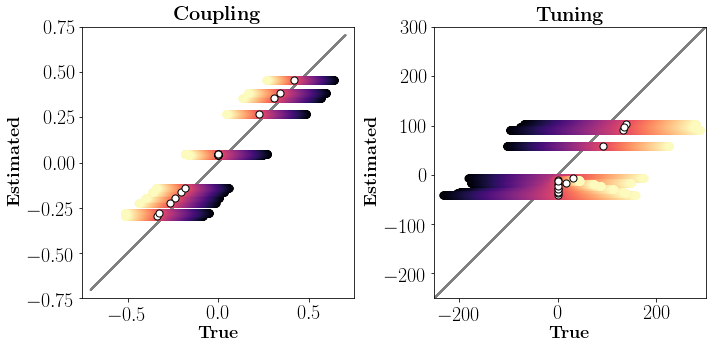

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for idx in range(n_deltas):
    plot.plot_tc_fits(a_hat, a_trues[idx],
                      b_hat, b_trues[idx],
                      color=plot.get_cmap_color('magma', val=idx, min_val=0, max_val=n_deltas),
                      edgecolor=None,
                      fax=(fig, axes))

plot.plot_tc_fits(a_hat, a_start,
                  b_hat, b_start,
                  color='white',
                  edgecolor='black',
                  fax=(fig, axes))

for ax in axes:
    ax.set_xlabel(r'\textbf{True}', fontsize=18)
    ax.set_ylabel(r'\textbf{Estimated}', fontsize=18)

axes[0].set_title(r'\textbf{Coupling}', fontsize=20)
axes[1].set_title(r'\textbf{Tuning}', fontsize=20)

axes[0].set_xlim([-0.75, 0.75])
axes[0].set_ylim([-0.75, 0.75])
axes[1].set_xlim([-250, 300])
axes[1].set_ylim([-250, 300])
plt.tight_layout()
plt.savefig('fits_vs_identifiability_no_selection_scatter.pdf', bbox_inches='tight')
plt.show()

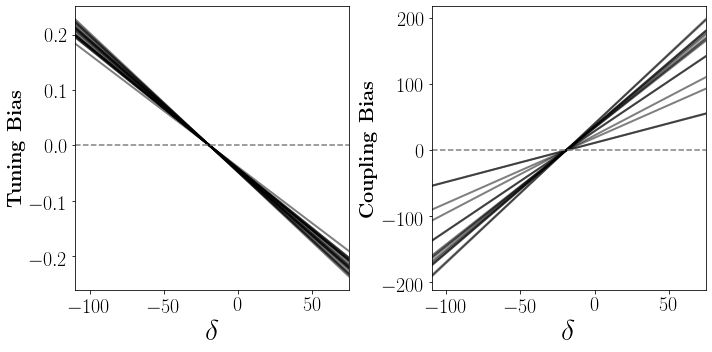

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

a_bias = a_trues - a_hat
b_bias = b_trues - b_hat

# iterate over coupling parameters
for idx in range(tm.N):
    # plot trajectory of parameter over delta
    axes[0].plot(deltas, a_bias[:, idx],
                 color='k',
                 alpha=0.5,
                 linewidth=2)

# iterate over coupling parameters
for idx in range(tm.M):
    # plot trajectory of parameter over delta
    axes[1].plot(deltas, b_bias[:, idx],
                 color='k',
                 alpha=0.5,
                 linewidth=2)
    
axes[0].set_ylabel(r'\textbf{Tuning Bias}', fontsize=20)
axes[1].set_ylabel(r'\textbf{Coupling Bias}', fontsize=20)

for ax in axes:
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xlim([-110, 75])
    ax.set_xlabel(r'$\delta$', fontsize=30)

plt.tight_layout()
plt.savefig('fits_vs_identifiability_no_selection_bias.pdf', bbox_inches='tight')

# Experiment 3: Performance of ITSFA

In [21]:
# create triangular model kwargs
tuning_kwargs, coupling_kwargs, noise_kwargs, stim_kwargs = \
    TriangularModel.generate_piecewise_kwargs(M=20, N=50, K=1,
                                              corr_cluster=0.2, corr_back=0.0,
                                              tuning_sparsity=0.6, coupling_sparsity=0.5,
                                              tuning_random_state=233332, coupling_random_state=2)

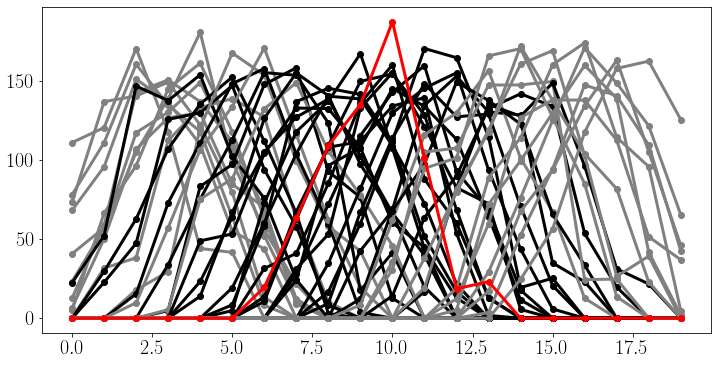

In [22]:
# create triangular model and examine tuning curves
tm = TriangularModel(
    model='linear',
    parameter_design='piecewise',
    tuning_kwargs=tuning_kwargs,
    coupling_kwargs=coupling_kwargs,
    noise_kwargs=noise_kwargs,
    stim_kwargs=stim_kwargs
)
tm.plot_tuning_curves(neuron='all')
plt.show()

In [23]:
n_deltas = 1000
n_reps = 20
deltas = np.linspace(-10, 10, n_deltas)
a_start = np.copy(tm.a.ravel())
b_start = np.copy(tm.b.ravel())
a_hats = np.zeros((n_deltas, n_reps, tm.N))
b_hats = np.zeros((n_deltas, n_reps, tm.M))

In [24]:
# calculate tuning/coupling parameters for each identifiability parameters
for idx, delta in enumerate(deltas):
    tm.identifiability_transform(delta=delta)

    for rep in range(n_reps):
        X, Y, y = tm.generate_samples(n_samples=1000)
        solver = isolver.ITSFASolver(X, Y, y.ravel(),
                                     a_mask=a_start != 0, b_mask=b_start != 0,
                                     B=tm.B)
        a_hats[idx, rep], b_hats[idx, rep], _ = solver.fit_itsfa(K=1)
    tm.identifiability_transform(delta=-delta)

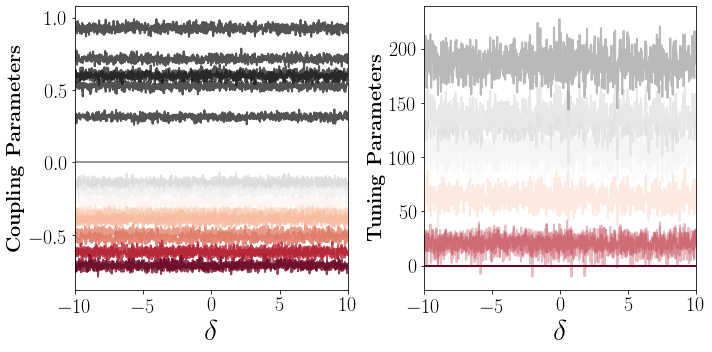

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# iterate over coupling parameters
for idx in range(tm.N):
    # plot trajectory of parameter over delta
    axes[0].plot(deltas, np.mean(a_hats[:, :, idx], axis=1),
                 color=plot.get_cmap_color('RdGy', a_start[idx], a_start.min(), a_start.max()),
                 alpha=0.75,
                 linewidth=2)

# iterate over coupling parameters
for idx in range(tm.M):
    # plot trajectory of parameter over delta
    axes[1].plot(deltas, np.mean(b_hats[:, :, idx], axis=1),
                 color=plot.get_cmap_color('RdGy', b_start[idx], b_start.min(), b_start.max()),
                 alpha=0.30,
                 linewidth=2)

axes[0].set_ylabel(r'\textbf{Coupling Parameters}', fontsize=20)
axes[1].set_ylabel(r'\textbf{Tuning Parameters}', fontsize=20)

for ax in axes:
    ax.set_xlim([-10, 10])
    ax.set_xlabel(r'$\delta$', fontsize=30)

plt.tight_layout()
plt.savefig('fits_vs_identifiability_itsfa_same_selection.pdf', bbox_inches='tight')